# Chapter 3 - Multi-armed bandits: maximizing business metrics while experimenting

- If you have a good A/B teting setup, the quality of your system should ramp up over time
- As that happens, most "B" tests will be *worse* than what you currently have
- Pay a cost in evaluating worse options - the revenue you would have made had you not had to try that system out
- We can make the cost cheaper by reframing the problem: "While evaluating a change candidate in production, how can we maximize the number of times we measure the better of A and B?"
	- [[Multi-Armed Bandit Problem]]
	- If A is better than B, we want to measure it more
	- Problem: We don't know that until we measure it!
- We'll first modify A/B testing to use summary staistics of individual measurements to choose which candidate to run: [[Epsilon-Greedy Algorithm]]
- Next: Tweak it to evaluate mutliple versions at once
- Using more detailed statistics of the measurement - [[Thompson Sampling]]

## Epsilon-greedy: Account for the impact of evaluation on business metrics
- Most proposed changes are rejected by A/B testing
    - Most of our ideas are not that good
- Scenario: imagine you're an ML engineer responsible for placing banner ads on a website.
    - Each time a user appears on the website, the model is queried for the probability they'll click on each of the ads in the inventory
    - Say 1000 ads in the inventory
    - System serves the ad with the highest predicted probability of being clicked by the user
    - Component of the system resonsile for selecting which ad to serve is the *ad selector*
    - If the user clicks on an ad, you get \$1, the cost per click (CPC)
    - Given the financial incentives, want to measure the Click-Through Rate (CTR):
$$
\text{CTR} = \frac{\text{# clicks on ads}}{\text{# ads shown}}
$$
    - Total revenue per day (broader business concern) is CPC * CTR * number of visitors to the page
    - You can try to get the ad managers to increase the CPC
    - Your job - increase the CTR by building a better model of the probability a user clicks an ad
    - The *click model*
    
### A/B Testing as a baseline
- In [[Chapter 2]], we developed A/B Testing with the goal of taking the fewest possible measurements consistent with a [False positive]] rate < `0.05` and a [[False Negative]] rate < `0.2`.
- These probabilities are unitless -> we can apply them to lots of different systems - no need for domain knowledge
- when optimizing an engineered system, we want to increase a business metric:
    - Use an experiment to determine whether A or B is better
    - Use the better one from now on
- Taking the measurement means exposing users to a potentially worse system - it has real costs
- Modify step 1: during the experiment we most often measure whichever version has the highest CTR
- Let's create a simulation
    - Current version: A, w/ a CTR of `0.005` (slightly below the average of 0.006)
    - Other version: B, w/ a CTR of `0.007` (slightly above the average)

In [1]:
# libraries, &c
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def measure_click(ctr):
    return 1 if np.random.uniform(0, 1) < ctr else 0

def measure_a():
    return measure_click(0.005)

def measure_b():
    return measure_click(0.007)

Now we run an A/B test following the steps in chapter 2:
1. Run a pilot study to measure sd_1_delta, which we abbreviate as sd_1
1. Define a practical significance level, `prac_sig`
1. Caculate the number of individual measurements to take, `num_ind`

Let's take `prac_sig = 0.001`. Given the 0.005 is our current CTR, an improvement of 0.001 would mean 20% more revenue per day!

In [3]:
def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)])
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)])
        sd_1 = np.sqrt(clicked_pre_a.std() ** 2 + clicked_pre_b.std() ** 2)
        return sd_1
    
    sd_1 = pilot_study(1000)
    prac_sig = 0.001
    num_ind = (2.48 * sd_1 / prac_sig) ** 2
    return int(num_ind)

In [4]:
np.random.seed(17)
num_ind = design_ab_test()
num_ind

91561

This tells us that we need nearly 100 000 measurements, which might seem like a lot. However, since the CTR is so small (and so the revenue is low), in order to stay in business an ad company must serve much more than this.

Now for the actual test:

In [5]:
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []
    for _ in range(num_ind):
        # randomize between A and B
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            clicked_a.append(clicked)
        else:
            clicked = measure_b()
            clicked_b.append(clicked)
    return np.array(clicked_a), np.array(clicked_b)
    
# complete the experiment by computing the z scores:
def analyze_ab_test(clicked_a, clicked_b):
    mean_a = clicked_a.mean()
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()
    std_b = clicked_b.std()
    m = mean_b - mean_a
    se = np.sqrt((std_a ** 2 + std_b ** 2) / num_ind)
    z = m / se
    
    return z # determines whether we accept or reject version B

In [6]:
# Complete experiment:
np.random.seed(17)
num_ind = design_ab_test()
print(num_ind)
clicked_a, clicked_b = run_ab_test(num_ind)
z = analyze_ab_test(clicked_a, clicked_b)
num_ind, z

91561


(91561, 2.954555022088617)

The z-score is 2.95 > 1.64 -> we accept this and switch over to model B.

Before the test we ran A (CTR: 0.005). After, we run B: (CTR: 0.007). During the test, we randomized btween them, so have a combined CTR of (0.005 + 0.007) / 2 = 0.006.

That means we have *regret* (technical term). The A/B test produced a regret of

CTR of model B - CTR of the A / B test = 0.007 - 0.006 = 0.001

We missed out on 0.001 CTR by running the test.

Let's go deeper into how the CTR evolves while running the test:

In [7]:
def ab_test(num_ind):
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for _ in range(num_ind):
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        if num_a > 0 and num_b > 0:
            ctr_a.append(sum_a / num_a)
            ctr_b.append(sum_b / num_b)
            ctr_vs_n.append(sum_clicks / num_ads)
    return ctr_vs_n, ctr_a, ctr_b

Text(0, 0.5, 'CTR Through n')

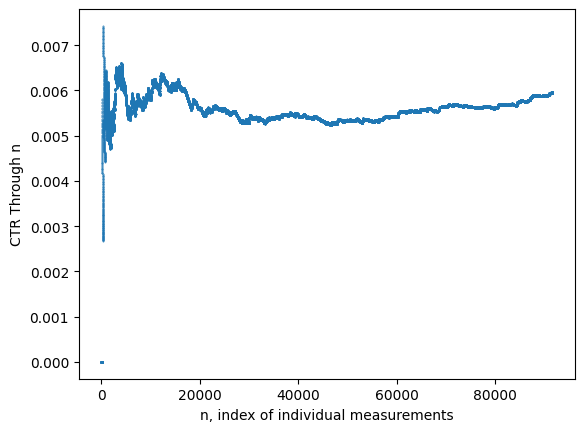

In [8]:
# Plot of one run
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
fig, ax = plt.subplots()
ax.scatter(range(len(ctr_vs_n)), ctr_vs_n, marker='.', s=0.5)
ax.set_xlabel("n, index of individual measurements")
ax.set_ylabel("CTR Through n")

Let's see the distribution over 100 runs:

In [9]:
all_runs = []
for _ in range(100):
    ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
    all_runs.append(ctr_vs_n)
means = []
upper_1_std = []
lower_1_std = []
for index in range(min(*[len(run) - 1 for run in all_runs])):
    measurements = np.array([run[index] for run in all_runs])
    mean = measurements.mean()
    std = measurements.std()
    means.append(mean)
    upper_1_std.append(mean + std)
    lower_1_std.append(mean - std)

Text(0, 0.5, 'Mean and 1 std around the CTR')

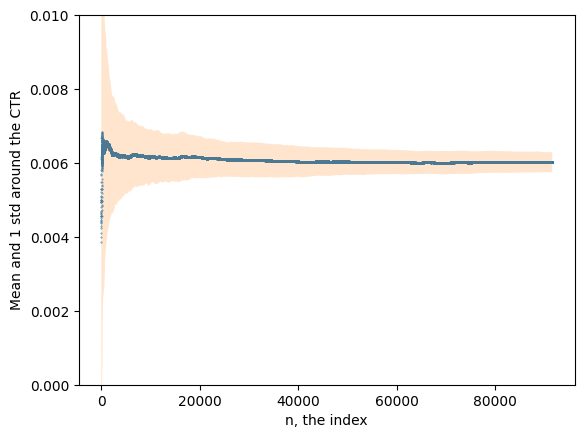

In [10]:
fig, ax = plt.subplots()
ax.scatter(range(len(means)), means, marker='.', s=0.5)
ax.fill_between(range(len(means)), lower_1_std, upper_1_std, alpha=0.2)
ax.set_ylim(0, 0.01)
ax.set_xlabel("n, the index")
ax.set_ylabel("Mean and 1 std around the CTR")

We can also plot the CTR for A vs B separately:

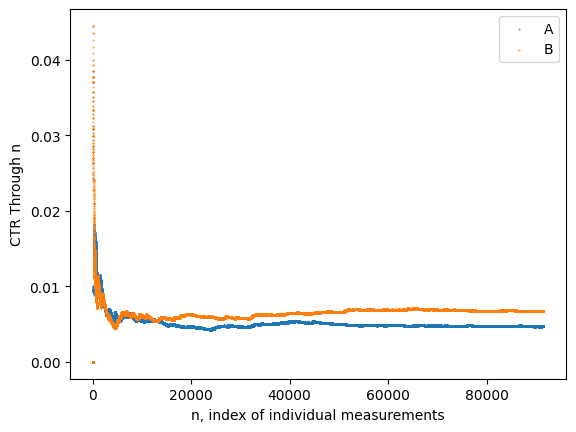

In [11]:
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
fig, ax = plt.subplots()
ax.scatter(range(len(ctr_a)), ctr_a, marker='.', s=0.5, label="A")
ax.scatter(range(len(ctr_b)), ctr_b, marker='.', s=0.5, label="B")
ax.set_xlabel("n, index of individual measurements")
ax.set_ylabel("CTR Through n")
ax.legend()

Looking at this graph, it would be tempting to stop around n=100 - when it is becoming clear that B is consistently outperforming A. This is well before our cutoff of 100 000! However, that runs the risk of false positives. One solution: the epsilon-greedy algorithm.

### The epsilon-greedy algorithm
Instead of choosing between A and B with equal probability, epsilon-greedy assigns a higher probability to whichever version has a higher CTR so far.

Works like this:

> With probability `1 - epsilon`, use the version with the higher CTR. otherwise, with probability epsilon, act like a regular A / B test and choose between them with equal probability

That means changing our model selection code from

```python
if np.random.uniform(0, 1) < 0.5:
    # Run A
else:
    # Run B
```

to 

```python
if np.random.uniform(0, 1) < 1 - epsilon:
    # run the one with higher CTR
else:
    if np.random.uniform(0, 1) < 0.5:
        # Run A
    else:
        # Run B
```

Note that if `epsilon=1`, the first branch never runs (behaves like a normal A / B test); if epsilon = 0, the first branch is always run. Thus, we can think of `epsilon` as controlling how greedy we are - 1 is no greed, 0 is always greedy!

Note also that `epsilon` is a paramter of the algorithm, not of the system. We refer to it as a *metaparameter*.

In [12]:
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    used_b = []
    for _ in range(num_ind):
        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
            elif ctr_a < ctr_b:
                select = "B"
        if select == 'Randomize':
            select = "A" if np.random.uniform(0, 1) < 0.5 else "B"
            
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
            used_b.append(False)
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
            used_b.append(True)
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        
    return ctr_vs_n, used_b

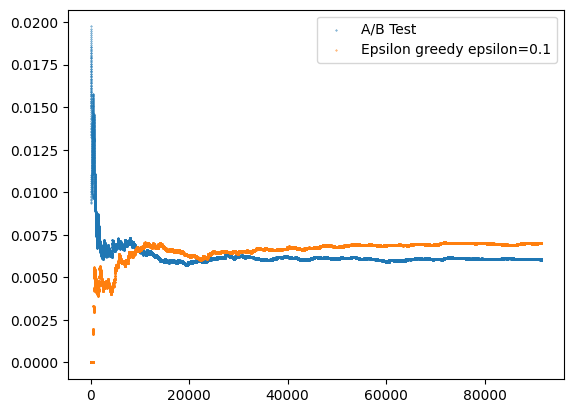

In [14]:
# comparing a run of epsilon_greedy with ab_test

epsilon = 0.1
epsilon_ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon=epsilon)
ab_test_ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)

fig, ax = plt.subplots()
min_n = min(len(epsilon_ctr_vs_n), len(ab_test_ctr_vs_n))
ax.scatter(range(min_n), ab_test_ctr_vs_n[:min_n], label="A/B Test", s=0.5, marker='.')
ax.scatter(range(min_n), epsilon_ctr_vs_n[:min_n], label=f"Epsilon greedy {epsilon=}", s=0.5, marker='.')
ax.legend()

So epsilon-greedy is outperforming the regular AB test - there's less regret!

Raw numbers:

In [20]:
print(epsilon_ctr_vs_n[-1], ab_test_ctr_vs_n[-1])
print(epsilon_ctr_vs_n[-1] - ab_test_ctr_vs_n[-1])

0.0070117189633140745 0.006061532748659363
0.0009501862146547111


So that's a pretty significant improvement! In fact, it's only slightly worse than the optimal - switching to B right at the beginning! (The actual number is higher, but that's just the last one)

In [37]:
NUM_RUNS = 100

all_ab_runs = []
for _ in range(NUM_RUNS):
    ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
    all_ab_runs.append(ctr_vs_n)
ab_means = []
ab_upper_1_std = []
ab_lower_1_std = []
max_length = min(*[len(run) for run in all_ab_runs])
for index in range(max_length):
    measurements = np.array([run[index] for run in all_ab_runs])
    mean = measurements.mean()
    std = measurements.std()
    ab_means.append(mean)
    ab_upper_1_std.append(mean + std)
    ab_lower_1_std.append(mean - std)
    
epsilon = 0.1
all_epsilon_runs = []
for _ in range(NUM_RUNS):
    ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon)
    all_epsilon_runs.append(ctr_vs_n)
epsilon_means = []
epsilon_upper_1_std = []
epsilon_lower_1_std = []
max_length = min(*[len(run) for run in all_epsilon_runs])
for index in range(max_length):
    measurements = np.array([run[index] for run in all_epsilon_runs])
    mean = measurements.mean()
    std = measurements.std()
    epsilon_means.append(mean)
    epsilon_upper_1_std.append(mean + std)
    epsilon_lower_1_std.append(mean - std)

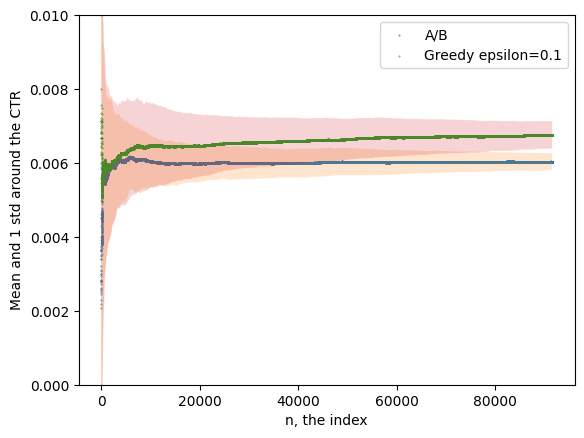

In [38]:
fig, ax = plt.subplots()

ax.scatter(range(len(ab_means)), ab_means, marker='.', s=0.5, label="A/B")
ax.fill_between(range(len(ab_means)), ab_lower_1_std, ab_upper_1_std, alpha=0.2)

ax.scatter(range(len(epsilon_means)), epsilon_means, marker='.', s=0.5, label=f"Greedy {epsilon=}")
ax.fill_between(range(len(epsilon_means)), epsilon_lower_1_std, epsilon_upper_1_std, alpha=0.2)

ax.set_ylim(0, 0.01)
ax.set_xlabel("n, the index")
ax.set_ylabel("Mean and 1 std around the CTR")
ax.legend()

We can also compare the number of times that B was chosen by epsilon-greedy. Recall that for a normal AB test, it would be chosen 50% of the time.

In [40]:
ctr_vs_n, used_b = epsilon_greedy(num_ind, epsilon)
percentage_b = []
total_b = 0
for index, was_b_used in enumerate(used_b):
    total_b += 1 if was_b_used else 0
    percentage_b.append(total_b / (index + 1))

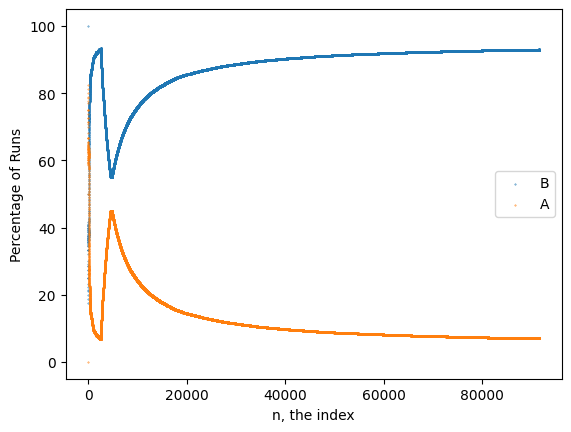

In [46]:
fig, ax = plt.subplots()
ax.scatter(range(len(percentage_b)), [percentage * 100 for percentage in percentage_b], marker='.', s=0.5, label="B")
ax.scatter(range(len(percentage_b)), [100 - percentage * 100 for percentage in percentage_b], marker='.', s=0.5, label="A")
ax.set_xlabel("n, the index")
ax.set_ylabel("Percentage of Runs")
ax.legend()

So you can see that pretty quickly, the percentage of time we're choosing B is converging on 1 - epsilon = 0.9.

Explorative measurements - the 10% that we always take to make sure we're not being fooled
Exploitative measurements - the 90% we're taking for the one we're pretty sure is better

The epsilon metaparameter controls how often we explore vs. exploit. With epsilon=0.1, we explore 10% of the time and exploit 90%. We say that epsilon-greedy "balances exploration with exploitation".

### Deciding When to Stop

In our formulation so far, there is no prescription to stop. Before, we chose `num_ind`, the number we would need for a regular A/B test. In reality, however, that is not quite correct - since we're smampling different numbers of A and B the number we calculated for the AB test doesn't apply.

The goal with epsilon-greedy is to maximize the business metric, the CTR. Slight modification to get it to stop: at each step, set
$$
\text{epsilon} = 2 \times c \times \frac{\left( \frac{\text{BM}_{\text{MAX}}}{\text{PS}} \right)^2}{n}
$$
where
- $\text{BM}_{\text{MAX}}$ is the largest plausible value of the business metric - say, 0.01. It's there to scale the practical significance so it becomes unitless
- $\text{PS}$ is the practical significance `prac_sig`
- $c$ controls how much time is spent in pure explortion

Note that epsilon is proportional to 1/n - it will decay towards 0. When epsilon is 1 or larger, it will *only* explore. When it falls below 1, it starts exploiting. We'll use $c=5$, but this should be carefully considered. Setting $c$ too high -> too much exploration; setting it too low -> starts exploiting too quickly and so may produce false positives / false negatives.

Note also that there is no dependence on the actual measurements - epsilon will decay on a fixed schedule.

We stop when epsilon gets below some fairly arbitrary threshold - say 0.02 or 0.005. The sensitivity to the exact threshold is low.

Basically, when the algorithm stops we check which one has the higher CTR and use that one.

In [47]:
def epsilon_greedy_decay():
    bm_max = 0.01
    prac_sig = 0.001
    c = 5
    
    epsilon_0 = 2 * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01
    
    sum_clicks = 0
    num_ads = 0
    sum_a = 0
    num_a = 0
    sum_b = 0
    num_b = 0
    
    ctr_vs_n = []
    epsilons = []
    
    n = 0
    selected = None
    while True:
        epsilon = min(1, epsilon_0 / (n + 1))
        epsilons.append(epsilon)
        if epsilon < epsilon_stop:
            break
            
        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
                selected = "A"
            elif ctr_a < ctr_b:
                select = "B"
                selected = "B"
        if select == 'Randomize':
            select = "A" if np.random.uniform(0, 1) < 0.5 else "B"
            
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1
        
    if selected == "B":
        accept_reject = "Accept"
    else:
        accept_reject = "Reject"
        
    return ctr_vs_n, epsilons, accept_reject

In [48]:
ctr_vs_n, epsilons, accept_reject = epsilon_greedy_decay()

Text(0, 0.5, 'epsilon')

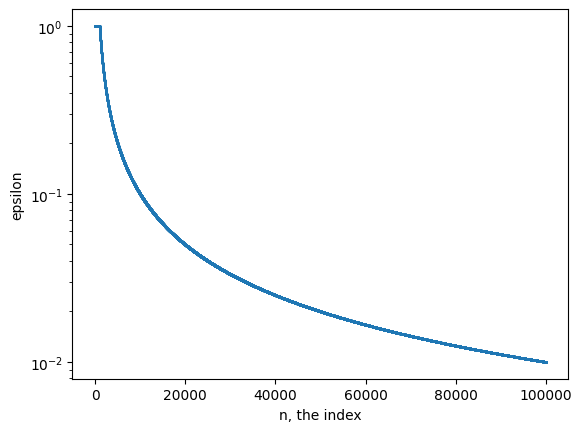

In [52]:
fig, ax = plt.subplots()
ax.scatter(range(len(epsilons)), epsilons, marker='.', s=0.5)
ax.set_yscale('log')
ax.set_xlabel("n, the index")
ax.set_ylabel("epsilon")

Note that this stopped after 100 000, below the recommended one of about 200 000.